<a href="https://colab.research.google.com/github/maloyan/HW_keras/blob/master/hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#DON'T FORGET TO CHANGE Runtime->GPU

import numpy as np
import pandas as pd
import random
import cv2
import gc
import os

import tensorflow as tf
import tensorflow_addons as tfa
import albumentations as A
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.metrics import RootMeanSquaredError, AUC
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input, Lambda, concatenate
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE

gc.enable()

%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
!nvidia-smi

Mon Jun 15 20:07:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    39W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [0]:
# Скачиваем архив с датасетом и распаковываем его архив
%%capture
if 'chest_xray' not in os.listdir('.'):
    !wget https://data.mendeley.com/datasets/rscbjbr9sj/2/files/f12eaf6d-6023-432f-acc9-80c9d7393433/ChestXRay2017.zip;
    !unzip ChestXRay2017.zip;

In [0]:
# Объявляем константы
NUM_CLASSES = 2
IMG_WIDTH, IMG_HEIGHT = 128, 128

TRAIN_DIR = './chest_xray/train/'
TEST_DIR = './chest_xray/test/'

EPOCHS = 30
BATCH = 32

TRAIN_SIZE = len(os.listdir('./chest_xray/train/NORMAL')) + len(os.listdir('./chest_xray/train/PNEUMONIA'))

TRAIN_STEPS = TRAIN_SIZE // BATCH

if K.image_data_format() == 'channels_first':
    INPUT_SHAPE = (1, IMG_WIDTH, IMG_HEIGHT)
else:
    INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 1)

In [0]:
# Для аугментации используем библиотеку Albumentation
# Особенность этой библиотеки в том, что можно указать вероятность применения вида аугментации
# Применяем горизонтальное отражение с вероятностью p=0.8
# Применяем сдвиг маштабирование поворот с вероятностью p=1
doc_aug = A.Compose([
    A.HorizontalFlip(p=0.8),
    A.ShiftScaleRotate(shift_limit=0.1625, scale_limit=0.2, rotate_limit=30, p=1)
], p=1)

NORMAL


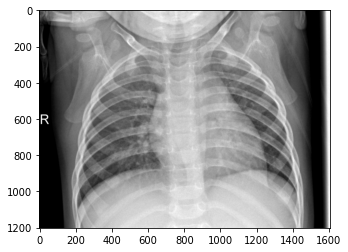

In [9]:
# Выведем пример снимка здорового человека
img_normal = cv2.imread('./chest_xray/train/NORMAL/' + os.listdir('./chest_xray/train/NORMAL')[0])

print('NORMAL')
plt.imshow(img_normal)
plt.show()

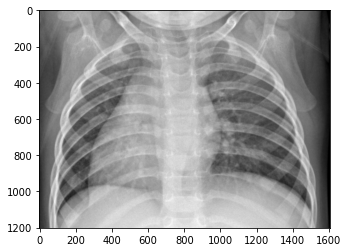

In [10]:
# Выведем изображение сверху при этом применим аугментацию
plt.imshow(doc_aug(image=img_normal, mask=None, bboxes=[], category_id=[])['image'])

PNEUMONIA


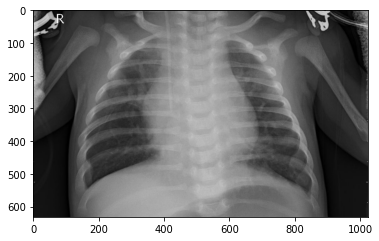

In [11]:
# Сделаем тоже самое для снимка больного
img_pneumonia = cv2.imread('./chest_xray/train/PNEUMONIA/' + os.listdir('./chest_xray/train/PNEUMONIA/')[0])

print('PNEUMONIA')
plt.imshow(img_pneumonia)
plt.show()

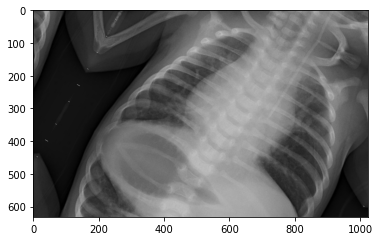

In [12]:
# Также посмотрим пример аугментации
plt.imshow(doc_aug(image=img_pneumonia, mask=None, bboxes=[], category_id=[])['image'])

In [0]:
# Так как датасет небольшой, то было решено не писать кастомный даталоадер
# Весь датасет целиком помещается в оперативную память, поэтому там и ее сохраним
def loadimgs(path, train_flag=False):
    # Объявляем массивы, где будем хранить данные X и метки y
    X = []
    y = []
    
    # Отдельно заведем массивы для аугментированных изображений
    if train_flag:
        X_aug = []
        y_aug = []
    # Пройдемся по всем файлам: больных и здоровых
    for ind, i in enumerate(['NORMAL', 'PNEUMONIA']):
        for file_path in os.listdir(path + '/' + i):
            # В архиве с данными есть файлы с метаданными
            # Для этого делаем проверку на то, что это изображение
            if file_path[-5:] == '.jpeg':
                # Считываем изображение через его путь
                img = cv2.imread(path + '/' + i + '/' + file_path)
                # Изображение изначально имеет три канала RGB
                # На самом деле каналы находятся в обратном порядке BGR
                # Но нам это неважно, так как мы переведем ее одноканальное ч/б изображние
                # Для этого используем cv2.COLOR_BGR2GRAY 
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                # Сжимаем изображение до нужных нам размеров
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT), interpolation = cv2.INTER_AREA)
                # На каждую фотку делаем 1 аугментацию
                if train_flag:
                    # Применяем правила аугментации, описанные выше
                    img_aug = doc_aug(image=img, mask=None, bboxes=[], category_id=[])['image']
                    # Изменяем размерность аугментированного изображение до нужного 
                    img_aug = img_aug.reshape(IMG_WIDTH, IMG_HEIGHT, 1)
                    # Переводим тип из int8 в float32
                    img_aug = img_aug.astype('float32')
                    # Нормализуем изображение деля на максимальное значение пикселя в RGB
                    img_aug /= 255
                    X_aug.append(img_aug)
                    y_aug.append(ind)
                # Изменяем размерность оригинального изображение до нужного
                img = img.reshape(IMG_WIDTH, IMG_HEIGHT, 1)
                # Переводим в нужный тип и нормализуем
                img = img.astype('float32')
                img /= 255
                
                X.append(img)
                y.append(ind)
    # Если это обучающая выборка, то возвращаем 4 массива
    # Если тест, то 2
    if train_flag:
        return np.stack(X), np.stack(y), np.stack(X_aug), np.stack(y_aug)
    return np.stack(X), np.stack(y)

In [0]:
# Выгружаем данные с помощью функции loadimgs, описанной выше
X_train, y_train, X_aug_train, y_aug_train = loadimgs('./chest_xray/train', train_flag=True)
X_test, y_test = loadimgs('./chest_xray/test')

In [0]:
# Строим модель
# Для этого напишем функцию базовой модели, которая в дальнейшем будет адаптироваться

def base_model(input_shape):
    # На вход подается картинка размерностью input_shape
    model = Sequential()

    # Используя фантазию получаем данную последовательность слоев
    model.add(Conv2D(32, (3, 3), input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Переводим выход предыдущего слоя в вектор размерности 64
    model.add(Flatten())
    model.add(Dense(64))

    return model

# Эта модель будет использоваться для получения числа в диапазоне (0, 1)
# Это число будет использовться для отнесения изображения к тому или иному классу
def classic_model(input_shape):
    # Берем базовую модель
    model = base_model(input_shape)
    # После его последнего слоя добавляем еще несколько
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    # Сожмем вектор в одно число
    model.add(Dense(1))
    # Применим функцию активации sigmoid, чтобы получить число в диапазоне (0, 1)
    model.add(Activation('sigmoid'))
    return model

# Реализация сиамской сети по аналогии с https://keras.io/examples/mnist_siamese/
def siamese_model(input_shape):
    # Объявим нужные нам функции посчета евклидово расстояния
    def euclidean_distance(vects):
        x, y = vects
        sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
        return K.sqrt(K.maximum(sum_square, K.epsilon()))

    def eucl_dist_output_shape(shapes):
        shape1, shape2 = shapes
        return (shape1[0], 1)

    # На вход подается пара изображений размерностью input_shape
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Объявим базовую модель, но к выходному вектору длиной 64 применим сигмоиду
    embedding_model = base_model(input_shape)
    embedding_model.add(Activation('sigmoid'))

    # Для каждого из пары изображений сделаем отдельно модель
    # Их архитектура и веса будут совпадать
    encoded_l = embedding_model(left_input)
    encoded_r = embedding_model(right_input)
    
    # Выходом нашей модели будет расстояние между эмбеддингами изображений
    # Для этого сделаем функцию посчета расстояния используя евклидово расстояние
    distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([encoded_l, encoded_r])

    # Опишем модель: на вход подается пара изображений, на выходе расстояние
    siamese_net = Model(inputs=[left_input,right_input],outputs=distance)

    # Вернем не только саму модель сиамской сети, но и еще модель, которая возвращает эмбеддинги
    # Это сделано с целью, чтобы не генерировать пары для тестовой выборки, 
    # а сразу получать эмбеддинги для каждого индивидуального изображения
    return embedding_model, siamese_net

# Модель с триплетами
def siamese_triplet_model(input_shape, triplet_margin=.3):
    # В триплетах подается три изображения: якорь, позитивный и негативный
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input")
    
    # Объявим базовую модель, но к выходному вектору длиной 64 применим сигмоиду
    embedding_model = base_model(input_shape)
    embedding_model.add(Activation('sigmoid'))

    # Для каждого из тройки изображений сделаем отдельно модель
    # Их архитектура и веса будут совпадать
    encoded_anchor = embedding_model(anchor_input)
    encoded_positive = embedding_model(positive_input)
    encoded_negative = embedding_model(negative_input)
    
    # Вход - три изображения
    # Выход - три эмбеддинга этих изображений
    inputs = [anchor_input, positive_input, negative_input]
    outputs = [encoded_anchor, encoded_positive, encoded_negative]
    
    # Объявим саму модель
    siamese_triplet = Model(inputs=inputs,outputs=outputs)
    
    # Объявим лосс, с помощью которого будем считать расстояния между эмбеддингами
    siamese_triplet.add_loss((triplet_loss(outputs)))
    
    # Вернем модель получения эмбеддингов и сиамскую модель для триплетов
    return embedding_model, siamese_triplet

In [0]:
# Функция, где происходит обучение 
def training_evaluation(X_train, y_train, build_model, loss):
    # Массивы для сохранения оценок качества на каждом фолде
    recall    = []
    precision = []

    # Разбиение на трейн и валидацию произведем с помощью StratifiedKFold
    # Это позволит сохранить баланс классов в таком виде, в котором он был изначально в трейне
    # Разбиваем на 5 фолдов, в skf запишутся индексы объектов для трейн и валидации на каждом фолде
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for i, (train_index, valid_index) in enumerate(skf.split(X_train, y_train)):
        # Объявляем колбек на раннюю остановку обучения
        # Обучение закончится, когда patience=2 эпохи подряд лосс на валидации не будет падать
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
        # Загружаем модель
        model = build_model(INPUT_SHAPE)
        # Объявляем в модели лосс, оптимайзер, и оценки качества
        # Везде в данной работе в качестве оптимайзера был взят Adam() с дефолтными значениями
        model.compile(
            loss=loss,
            optimizer=optimizers.Adam(),
            # Оценки качества беруется по дефолту, порог у каждой из них 0.5
            metrics=[
                tf.keras.metrics.Recall(), 
                tf.keras.metrics.Precision()
            ]
        )
        # Обучаем модель: подаем фолд для трейна с его метками
        model.fit(
            x = X_train[train_index],
            y = y_train[train_index],
            batch_size=BATCH,
            epochs=EPOCHS,
            validation_data=(X_train[valid_index], y_train[valid_index]),
            callbacks=[callback],
            verbose=0 # чтобы не отображался процесс обучения
        )
        # Проводим подсчет оценок качества на тестовой выборке
        eval = model.evaluate(X_test, y_test)
        precision.append(eval[1])
        recall.append(eval[2])
        gc.collect()

    print('RECALL: ', np.mean(precision), np.std(precision))
    print('PRECISION: ', np.mean(recall), np.std(recall))
    return precision, recall

In [0]:
# Создаем пары для сиамской сети
def create_pairs(x, y):
    # Находим индексы для каждого из классов
    digit_indices = [np.where(y == i)[0] for i in range(NUM_CLASSES)]
    pairs = []
    labels = []
    # n - количество экземпляров в классе, где меньше всего изображений 
    n = min([len(digit_indices[d]) for d in range(NUM_CLASSES)]) - 1
    for d in range(NUM_CLASSES):
        # Для каждого из изображений ставим в пару его соседнее изображение по индексу из digit_indecies
        # Создаюм одну пару из одного класса и одну пару из разных
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            
            dn = (d + 1) % NUM_CLASSES
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]

            labels += [1, 0]

    return np.array(pairs), np.array(labels)
    
# Contrastive loss из Hadsell-et-al.'06
# http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# Эта функция обученную KNN с помощью которой мы будем относить эмбедденги из сиамских сетей
# к тому или иному классу 
def fit_nearest_neighbor(img_encoding, img_class, n_neighbors, algorithm='ball_tree'):
    classifier = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=algorithm)
    classifier.fit(img_encoding, img_class)
    return classifier

# Обучение сиамской сети с парами
def training_evaluation_siamese(X, y, build_model, loss):
    recall    = []
    precision = []
    # Разбиваем на фолды
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
        # колбек на early stopping
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
        
        # получаем две модели: для получения эмбеддинга одной картинки 
        # и модель для обучения на парах 
        embedding_model, model = build_model(INPUT_SHAPE)
        
        model.compile(
            loss=loss,
            optimizer=optimizers.Adam(),
        )

        model.fit(
            x = [X[train_index][:, 0], X[train_index][:, 1]],
            y = y[train_index],
            batch_size=BATCH,
            epochs=EPOCHS,
            validation_data=([X[valid_index][:, 0], X[valid_index][:, 1]], y[valid_index]),
            callbacks=[callback],
            verbose=0
        )

        # С помощью модели для генерации эмбеддингов получаем эмбеддинги для обучающей выборки
        train_embeds = embedding_model.predict(X_train)
        # На основе этих эмбеддингов строим классификатор KNN
        classifier = fit_nearest_neighbor(train_embeds, y_train, 10)
        # Получаем эмбеддинги тестовой выборки
        e = embedding_model.predict(X_test)
        # Предсказываем к какому из классов относятся эмбеддинги тестовой выборки
        op = classifier.predict(e)

        # Считаем метрики качества
        m = tf.keras.metrics.Precision()
        _ = m.update_state(op, y_test)
        precision.append(m.result().numpy())

        m = tf.keras.metrics.Recall()
        _ = m.update_state(op, y_test)
        recall.append(m.result().numpy())

        gc.collect()
    print('RECALL: ', np.mean(precision), np.std(precision))
    print('PRECISION: ', np.mean(recall), np.std(recall))
    return precision, recall, e

In [0]:
# Функция генерации триплетов 
def generate_triplets(dataset, label, sample_per_class=10):
    x, y = None, None
  # Генерируем триплеты для 2х классов
    for i in range(2):
        # Получаем индексы изображений для каждого из классов
        pos_indices = np.argwhere(label == i)[:,0]
        neg_indices = np.argwhere(label != i)[:,0]

        # Выбираем рандомно в количестве sample_per_class индексов для якорей
        choice_anchor = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
        choice_anchor = pos_indices[choice_anchor]

        # Столько же выбираем на рандоме индексы изображений из позитивного и негавного класса
        choice_pos = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
        choice_pos = pos_indices[choice_pos]

        choice_neg = np.random.choice(neg_indices.shape[0], sample_per_class, replace=False)
        choice_neg = neg_indices[choice_neg]

        # По индексам собираем сами изображения
        sub_x_anc = dataset[choice_anchor]
        
        sub_x_pos = dataset[choice_pos]

        sub_x_neg = dataset[choice_neg]
        
        # Собираем эти три массива в один триплет 
        if(x is None):
            x = [(sub_x_anc), (sub_x_pos), (sub_x_neg)]
            y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
        else:
            x[0] = np.vstack((x[0], (sub_x_anc)))
            x[1] = np.vstack((x[1], (sub_x_pos)))
            x[2] = np.vstack((x[2], (sub_x_neg)))

            y[0] = np.hstack((y[0].flatten(), label[choice_anchor].flatten()))
            y[1] = np.hstack((y[1].flatten(), label[choice_pos].flatten()))
            y[2] = np.hstack((y[2].flatten(), label[choice_neg].flatten()))
            
    return x, y

# Триплет лосс 
# https://arxiv.org/pdf/1503.03832.pdf
def triplet_loss(inputs):
    margin = 1
    anchor, positive, negative = inputs

    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)

    positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
    negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    
    loss = positive_distance - negative_distance
    loss = K.maximum(0.0, margin + loss)
    return K.mean(loss)

# Обучение на триплетах
def training_evaluation_siamese_triple(X, y, build_model):
    recall    = []
    precision = []
    # Разбиваем на фолды
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)
    for i, (train_index, valid_index) in enumerate(skf.split(X[0], y[0])):
        print(f'FOLD {i}')
        # Колбек на earlyStopping
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
        # Объявляем модель для эмбеддингов и для обучения на триплетах
        embedding_model, model = build_model(INPUT_SHAPE)
        
        model.compile(
            # Лосс оставляем пустым, так как лосс у нас объявлен в самой модели
            loss=None,
            optimizer=optimizers.Adam(),
        )
        
        model.fit(
            x = [X[0][train_index], X[1][train_index], X[2][train_index]],
            y = [y[0][train_index], y[1][train_index], y[2][train_index]],
            batch_size=BATCH,
            epochs=EPOCHS,
            validation_data=(
                [X[0][valid_index], X[1][valid_index], X[2][valid_index]], 
                [y[0][valid_index], y[1][valid_index], y[2][valid_index]]
            ),
            callbacks=[callback],
            verbose=0
        )

        # Получаем эмбеддинги и строим классификатор так же как и в модели с парами
        train_embeds = embedding_model.predict(X_train)
        classifier = fit_nearest_neighbor(train_embeds, y_train, 10)
        e = embedding_model.predict(X_test)
        op = classifier.predict(e)

        m = tf.keras.metrics.Precision()
        _ = m.update_state(op, y_test)
        precision.append(m.result().numpy())

        m = tf.keras.metrics.Recall()
        _ = m.update_state(op, y_test)
        recall.append(m.result().numpy())

        #gc.collect()
    print('RECALL: ', np.mean(precision), np.std(precision))
    print('PRECISION: ', np.mean(recall), np.std(recall))
    return precision, recall, e

In [0]:
# Функция визуализации эмбеддингов с помощью TSNE
def visualize_embedding(e):
    X_embedded = TSNE(n_components=2, perplexity=50, random_state=42).fit_transform(e)
    viz_df = pd.DataFrame({'x': X_embedded[:, 0], 'y': X_embedded[:, 1]})
    viz_df['color'] = ["#56E813" if i == 0 else "#0059FF" for i in y_test]
    
    sns.regplot(data=viz_df, x="x", y="y", fit_reg=False, scatter_kws={'facecolors':viz_df['color']})

In [28]:
# Модель с лосом бинарная кроссэнтропия 
gc.collect()
precision, recall = training_evaluation(
    X_train, 
    y_train, 
    classic_model, 
    tf.keras.losses.BinaryCrossentropy()
)

20/20 [==============================] - 0s 5ms/step - loss: 3.3282 - recall_10: 0.9974 - precision_10: 0.7060
RECALL:  0.9948717832565308 0.0028088225785594637
PRECISION:  0.7339117884635925 0.01729730533907014


In [0]:
# Модель с лосом бинарная кроссэнтропия на данных с применением аугментации
gc.collect()
precision, recall = training_evaluation(
    np.append(X_train, X_aug_train, axis=0), 
    np.append(y_train, y_aug_train, axis=0), 
    classic_model, 
    tf.keras.losses.BinaryCrossentropy()
)

20/20 [==============================] - 0s 12ms/step - loss: 2.6056 - recall_9: 0.9949 - precision_9: 0.7376
RECALL:  0.9958974242210388 0.0012561339110737652
PRECISION:  0.7340507268905639 0.008803739207302617


In [0]:
# Модель с лосом бинарная кроссэнтропия со сглаживанием
gc.collect()
precision, recall = training_evaluation(
    X_train, 
    y_train, 
    classic_model, 
    tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)
)

20/20 [==============================] - 0s 12ms/step - loss: 0.6448 - recall_14: 0.9923 - precision_14: 0.7357
RECALL:  0.9933333158493042 0.001256163111266965
PRECISION:  0.7231302261352539 0.008131234571682496


In [0]:
# Модель с лосом бинарная кроссэнтропия со сглаживанием на данных с применением аугментации
gc.collect()
precision, recall = training_evaluation(
    np.append(X_train, X_aug_train, axis=0), 
    np.append(y_train, y_aug_train, axis=0),  
    classic_model, 
    tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1)
)

20/20 [==============================] - 0s 12ms/step - loss: 0.7069 - recall_19: 0.9949 - precision_19: 0.7106
RECALL:  0.9928205013275146 0.001918801731569938
PRECISION:  0.729362690448761 0.01064478688684669


RECALL:  0.9912821 0.002051282
PRECISION:  0.7187451 0.018051187


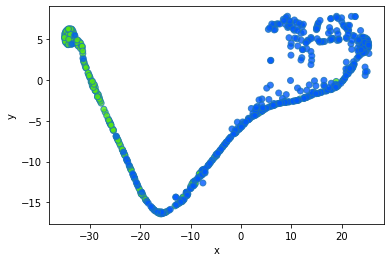

In [0]:
# Сиамская сеть на парах с contrastive loss
gc.collect()
tr_pairs, tr_y = create_pairs(X_train, y_train)

precision, recall, e = training_evaluation_siamese(
    tr_pairs, 
    tr_y,
    siamese_model, 
    contrastive_loss
)

visualize_embedding(e)

RECALL:  0.9907692 0.0047557107
PRECISION:  0.7197572 0.012952229


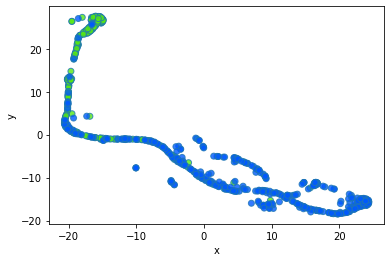

In [0]:
# Сиамская сеть на парах с contrastive loss на данных с применением аугментации
gc.collect()
tr_aug_pairs, tr_aug_y = create_pairs(np.append(X_train, X_aug_train, axis=0), np.append(y_train, y_aug_train, axis=0))

precision, recall, e = training_evaluation_siamese(
    tr_aug_pairs, 
    tr_aug_y,
    siamese_model, 
    contrastive_loss
)

visualize_embedding(e)

FOLD 0
FOLD 1
FOLD 2
FOLD 3
FOLD 4
RECALL:  0.9902564 0.0019187954
PRECISION:  0.73077905 0.011052449


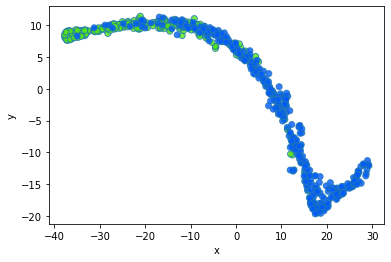

In [0]:
# Сиамская сеть на триплетах с triplet loss
gc.collect()
train_x, train_y = generate_triplets(X_train, y_train, 1349)

precision, recall, e = training_evaluation_siamese_triple(
    train_x, 
    train_y,
    siamese_triplet_model
)

visualize_embedding(e)

FOLD 0
FOLD 1
FOLD 2
FOLD 3
FOLD 4
RECALL:  0.98717946 0.0053785127
PRECISION:  0.74471986 0.0044441824


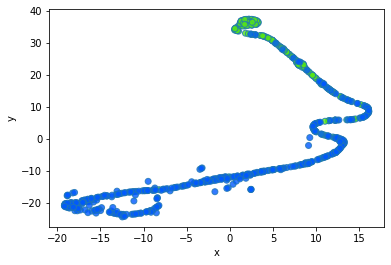

In [0]:
# Сиамская сеть на триплетах с triplet loss на данных с применением аугментации
gc.collect()
train_aug_x, train_aug_y = generate_triplets(np.append(X_train, X_aug_train, axis=0), np.append(y_train, y_aug_train, axis=0), 1349*2)

precision, recall, e = training_evaluation_siamese_triple(
    train_aug_x, 
    train_aug_y,
    siamese_triplet_model
)

visualize_embedding(e)

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18_input (InputLayer) [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 126, 126, 32)      320       
Total params: 320
Trainable params: 320
Non-trainable params: 0
_________________________________________________________________
None


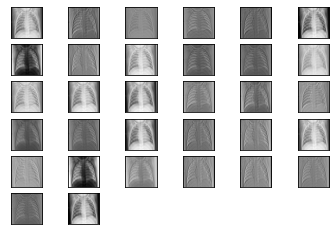

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18_input (InputLayer) [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
activation_30 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 61, 61, 32)        9248      
Total params: 9,568
Trainable params: 9,568
Non-trainable params: 0
_________________________________________________________________
None


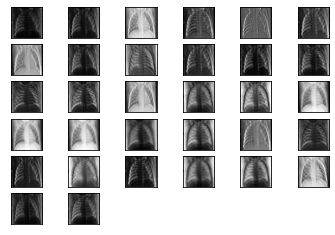

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18_input (InputLayer) [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
activation_30 (Activation)   (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
activation_31 (Activation)   (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 30, 30, 32)        0  

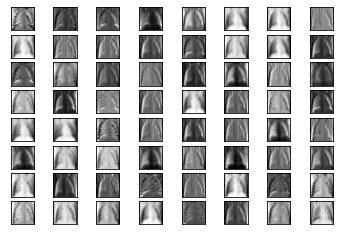

In [89]:
# Бонус
# Выведем изображения, которые прошли через промежуточные слои
# Для это натренируем еще раз нашу базовую модель 5 эпох
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
model = classic_model(INPUT_SHAPE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=optimizers.Adam(),
    metrics=[
        tf.keras.metrics.Recall(), 
        tf.keras.metrics.Precision()
    ]
)
model.fit(
    x = X_train,
    y = y_train,
    batch_size=BATCH,
    epochs=5,
    callbacks=[callback],
    verbose=0
)

# И выведем выходы conv слоев - это 0, 3 и 6 слой
for i in [0, 3, 6]:
    # Вход картинка, выход слоя
    model_cnn = Model(inputs=model.inputs, outputs=model.layers[i].output)
    print(model_cnn.summary())
    # Прогоним две картинки, так как лень было делать решейп :)
    feature_maps = model_cnn.predict(X_train[:2])
    # Выводим с помощью plt
    if i != 6:
        square = 6
        j = 4
    else:
        square = 8
        j = 8
    ix = 1
    for _ in range(8):
        for _ in range(j):
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
            ix += 1
    plt.show()